# (E17)17th_Project-Movie_Session_based_Recommendation
***
## 1. 데이터 불러오기
## 2. 데이터 분석하기
## 3. 데이터 전처리
## 4. 모델 구성 & 학습하기
## 5. 모델 성능 비교하기
***

## 1. 데이터 불러오기

      Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작하는 익스플로레이션입니다.
(http://files.grouplens.org/datasets/movielens/ml-1m.zip)

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

      데이터를 불러와서 칼럼과 내용을 확인합니다.

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


      노드에서 진행했던 세션ID는 유저ID로, 시간은 1970년 1월 1일부터 경과된 시간을 초단위로 나타낸 것입니다. 전에 진행했던 영화 추천 모델에선 Rating이 낮은 리뷰는 제거하였지만 이번엔 제거하지않고 그대로 진행합니다.

## 2. 데이터 분석하기

### 2-1. 유저 수 분석

      유저와 아이템(영화)의 유일한 갯수를 찾아봅니다.

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

      유저 별 아이템 갯수를 확인합니다.

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

      유저 별 아이템의 중간값, 평균값, 최소값, 최대값을 확인합니다.

In [5]:
user_length.median(), user_length.mean()

(96.0, 165.5975165562914)

In [6]:
user_length.min(), user_length.max()

(20, 2314)

      99.9%에 속하는 아이템의 갯수를 확인합니다.

In [7]:
user_length.quantile(0.999)

1343.181000000005

      단일로 아이템을 가장 많이 가진 유저가 중복된 값을 가지지 않았나 확인해봅니다.

In [8]:
long_session = user_length[user_length==2314].index[0]
data[data['UserId']==long_session].nunique()

UserId       1
ItemId    2314
Rating       5
Time       684
dtype: int64

      단일로 아이템을 가장 적게 가진 유저(들)가 중복된 값을 가지고 있는지 확인합니다.

In [9]:
short_session = user_length[user_length==20].index[0]
data[data['UserId']==short_session].nunique()

UserId     1
ItemId    20
Rating     5
Time      14
dtype: int64

      리뷰 하위 99.9%의 분포표를 확인해봅니다.

In [10]:
length_count = user_length.groupby(user_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

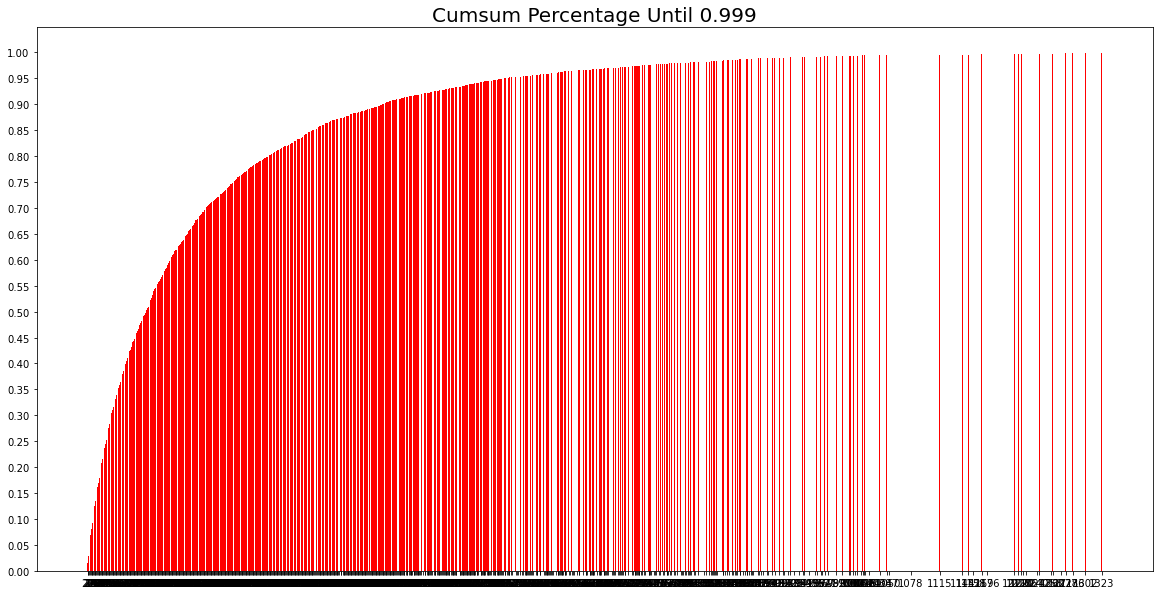

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### 2-2. 영화 수 분석

      이번엔 아이템의 수를 확인해봅니다.

In [12]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

      아이템의 중간값, 평균값, 최소값, 최대값을 확인합니다.

In [13]:
item_length.median(), item_length.mean()

(123.5, 269.88909875876953)

In [14]:
item_length.min(), item_length.max()

(1, 3428)

      하위 8%의 적은 갯수를 가진 아이템을 확인합니다.

In [15]:
item_length.quantile(0.08)

5.0

      하위 8%, 즉 5개 이하의 평가를 가진 아이템을 확인합니다.

In [16]:
short_item = item_length[item_length==5].index[0]
data[data['ItemId']==short_item]

,UserId,ItemId,Rating,Time
100954,673,167,5,975620192
138640,889,167,3,975261879
422323,2557,167,3,974448727
594164,3618,167,3,967119061
953194,5755,167,4,958282132


      하위 8%의 아이템의 리뷰 누적 확률 그래프를 그려서 확인합니다.

In [17]:
length_count = item_length.groupby(item_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_08 = length_percent_cumsum[length_percent_cumsum < 0.09]

length_percent_cumsum_08

1    0.030761
2    0.054776
3    0.066109
4    0.078251
5    0.088775
dtype: float64

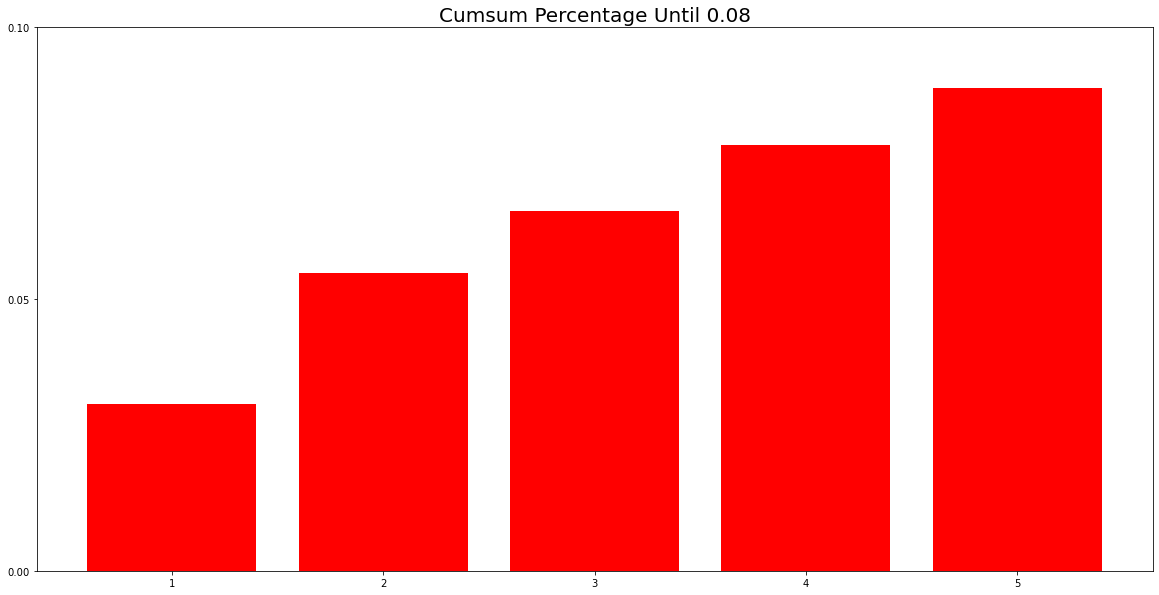

In [18]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_08.index,
        height=length_percent_cumsum_08, color='red')
plt.xticks(length_percent_cumsum_08.index)
plt.yticks(np.arange(0, 0.101, 0.05))
plt.title('Cumsum Percentage Until 0.08', size=20)
plt.show()

### 2-3. 리뷰 작성 날 분석

      학습 셋을 분리하기 위해 리뷰의 작성 기간을 확인합니다.

In [19]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [20]:
oldest/(3600*24*365), latest/(3600*24*365)

(30.33688267376966, 33.18285736935566)

      1970년 1월 1일로부터 약 30년 뒤에서 33년까지, 즉 2000~2003년 사이에 작성된 리뷰들로 데이터가 이루어져있습니다.

## 3. 데이터 전처리

### 3-1. 데이터 클렌징

In [21]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_review) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_review)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_review):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_review].index
    data = data[data['ItemId'].isin(item_use)]
    return data

      최저 사용자 수는 20으로 설정해서 모든 데이터를 활용하고, 최소 리뷰는 5개로 설정해서 하위 8%의 적은 평가를 받은 영화는 삭제해줍니다.

In [22]:
data = cleanse_recursive(data, shortest=20, least_review=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


### 3-2. 학습, 검증, 테스트 셋 분리하기

      위에서 날자를 변경해서 알아본 바, 약 4년 동안 기록된 데이터들입니다. 여기서 학습과 검증 데이터를 나눌 때 한달을 기준으로 나눠주기 위해서 n_days로 받은 인자에 한달(30일)을 초로 바꾼 2592000을 곱해줘서 최종 리뷰 작성 시간에서 빼서 데이터를 나눠줍니다.

In [23]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - 2592000*n_days].index
    session_in_test = session_last_time[session_last_time >= final_time - 2592000*n_days].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

      테스트와 검증은 각각 한달을 간격으로 데이터 셋을 가지게 되고 나머지는 학습 데이터로 활용하게 됩니다.

In [24]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [25]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

      각각의 데이터 셋에 데이터가 얼마나 들어가있는지 확인해봅니다.

In [26]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 919112
	 Users: 5853
	 Items: 3415
	 First Time : 956703932
	 Last Time : 1041215174

* valid Set Stats Info
	 Events: 29477
	 Users: 79
	 Items: 2960
	 First Time : 957547221
	 Last Time : 1043809240

* test Set Stats Info
	 Events: 50924
	 Users: 103
	 Items: 3171
	 First Time : 957179713
	 Last Time : 1046454590



      데이터 셋을 나눈 뒤, 학습 데이터에 없는 아이템이 검증, 테스트 셋에 나타날 수 있으므로 인덱싱을 학습 데이터 기준으로 해주고 나머지도 바꾸고 없는 아이템은 -1로 반환해줍니다.

In [27]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [28]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

In [29]:
class SessionDataset:
    
    def __init__(self, data):
        self.df = data
        self.review_offsets = self.get_review_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_review_offsets(self):        
        #Return the indexes of the first item of each session IDs,
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [30]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [31]:
tr_dataset.review_offsets

array([     0,     53,    182, ..., 918648, 918771, 919112], dtype=int32)

In [32]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 5850, 5851, 5852])

In [33]:
class SessionDataLoader:
  
    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
      # Returns the iterator for producing session-parallel training mini-batches.
        #Yields:
        #   input (B,):  Item indices that will be encoded as one-hot vectors later.
        #  target (B,): a Variable that stores the target item indices
        #  masks: Numpy array indicating the positions of the sessions to be terminated
        #

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        
        #start : Index Where Session Start
        #end : Index Where Session End
        #mask : indicator for the sessions to be terminated
        

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.review_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.review_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.review_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.review_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [34]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,978300019,0
22,1,1270,5,978300055,1
27,1,1721,4,978300055,2
37,1,1022,5,978300055,3
24,1,2340,3,978300103,4
36,1,1836,5,978300172,5
3,1,3408,4,978300275,6
7,1,2804,5,978300719,7
47,1,1207,4,978300719,8
0,1,1193,5,978300760,9


In [35]:
iter_ex = iter(tr_data_loader)

In [36]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 65 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


## 4. 모델 구성 & 학습하기

      모델은 노드에서 제공된 모델을 사용합니다.
      다양한 하이퍼 파라미터를 비교하기 위해서 RNN층의 갯수와 Drop Out의 갯수를 달리하면서 비교를 진행합니다.

In [37]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [39]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [40]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [42]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

In [46]:
args_25_1 = Args(tr, val, test, batch_size=64, hsz=25, drop_rate=0.1, lr=0.001, epochs=3, k=20)
args_50_1 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
args_100_1 = Args(tr, val, test, batch_size=64, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)
args_50_2 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.2, lr=0.001, epochs=3, k=20)
args_50_4 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.4, lr=0.001, epochs=3, k=20)

      RNN층이 25, 50, 100일 때와, RNN이 같을 때, Drop Out이 0.1, 0.2, 0.4일 때를 비교해줬습니다.
      성능의 우위는 학습이 끝나고 난 뒤 MRR이 클수록 성능이 좋다고 판단했습니다.

In [47]:
model_25_1 = create_model(args_25_1)
model_50_1 = create_model(args_50_1)
model_100_1 = create_model(args_100_1)
model_50_2 = create_model(args_50_2)
model_50_4 = create_model(args_50_4)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3415)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 25), (64, 25)]      258150    
_________________________________________________________________
dropout_5 (Dropout)          (64, 25)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3415)                88790     
Total params: 346,940
Trainable params: 346,940
Non-trainable params: 0
_________________________________________________________________
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(64, 1, 3415)]           0         
____________________________________

In [48]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model_25_1, args_25_1)

Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.09]

	 - Recall@20 epoch 1: 0.213263
	 - MRR@20    epoch 1: 0.053153



Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.74]

	 - Recall@20 epoch 2: 0.267295
	 - MRR@20    epoch 2: 0.068929



Evaluation:  29%|██▊       | 131/459 [00:23<00:59,  5.48it/s]

	 - Recall@20 epoch 3: 0.289957
	 - MRR@20    epoch 3: 0.077230



In [49]:
train_model(model_50_1, args_50_1)

Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.68]

	 - Recall@20 epoch 1: 0.251431
	 - MRR@20    epoch 1: 0.065077



Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.3] 

	 - Recall@20 epoch 2: 0.290673
	 - MRR@20    epoch 2: 0.082640



Evaluation:  29%|██▊       | 131/459 [00:23<00:59,  5.51it/s]

	 - Recall@20 epoch 3: 0.308087
	 - MRR@20    epoch 3: 0.089986



In [51]:
train_model(model_100_1, args_100_1)

Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.35]

	 - Recall@20 epoch 1: 0.279819
	 - MRR@20    epoch 1: 0.078394



Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.19]

	 - Recall@20 epoch 2: 0.305582
	 - MRR@20    epoch 2: 0.091284



Evaluation:  29%|██▊       | 131/459 [00:23<00:59,  5.50it/s]

	 - Recall@20 epoch 3: 0.314766
	 - MRR@20    epoch 3: 0.095149



In [52]:
train_model(model_50_2, args_50_2)

Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.77]

	 - Recall@20 epoch 1: 0.249523
	 - MRR@20    epoch 1: 0.064782



Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.48]

	 - Recall@20 epoch 2: 0.289361
	 - MRR@20    epoch 2: 0.080656



Evaluation:  29%|██▊       | 131/459 [00:23<00:58,  5.61it/s]

	 - Recall@20 epoch 3: 0.304151
	 - MRR@20    epoch 3: 0.089594



In [53]:
train_model(model_50_4, args_50_4)

Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0, train_loss=5.83]     

	 - Recall@20 epoch 1: 0.243201
	 - MRR@20    epoch 1: 0.063458



Train:   0%|          | 0/14269 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.91]

	 - Recall@20 epoch 2: 0.281966
	 - MRR@20    epoch 2: 0.076490



Evaluation:  29%|██▊       | 131/459 [00:24<01:00,  5.39it/s]

	 - Recall@20 epoch 3: 0.293774
	 - MRR@20    epoch 3: 0.082589



      일단 RNN층을 각각 25, 50, 100일 때, MRR이 각각 0.077, 0.090, 0.095로 성능이 상승했고,
      Drop Out이 각각 0.1, 0.2, 0.4일 때, MRR이 각각 0.08999, 0.08960, 0.08260으로 하락했습니다.
      
      결론적으로 RNN이 두터워질수록 성능이 올라가고, Drop Out은 거의 영향을 미치지 않지만 올라갈수록 성능이 하락했습니다.

## 5. 모델 성능 비교하기

      위에 학습을 마친 모델을 각각 테스트 셋으로 성능을 확인합니다.

In [54]:
test_model(model_25_1, args_25_1, test)

Evaluation:  53%|█████▎    | 418/794 [01:18<01:10,  5.34it/s]

	 - Recall@20: 0.260130
	 - MRR@20: 0.069439



In [55]:
test_model(model_50_1, args_50_1, test)

Evaluation:  53%|█████▎    | 418/794 [01:17<01:09,  5.42it/s]

	 - Recall@20: 0.286446
	 - MRR@20: 0.082498



In [57]:
test_model(model_100_1, args_100_1, test)

Evaluation:  53%|█████▎    | 418/794 [01:16<01:08,  5.46it/s]

	 - Recall@20: 0.293698
	 - MRR@20: 0.088146



In [58]:
test_model(model_50_2, args_50_2, test)

Evaluation:  53%|█████▎    | 418/794 [01:17<01:09,  5.41it/s]

	 - Recall@20: 0.282484
	 - MRR@20: 0.080400



In [59]:
test_model(model_50_4, args_50_4, test)

Evaluation:  53%|█████▎    | 418/794 [01:17<01:10,  5.36it/s]

	 - Recall@20: 0.273550
	 - MRR@20: 0.076940



      RNN층이 25, 50, 100일 때, MRR이 0.070, 0.082, 0.088로 성능이 올라가는 것을 확인할 수 있었고,
      Dorp Out이 0.1, 0.2, 0.4로 올라갈 때, 0.0825, 0.0800, 0.0769로 성능이 하락하는 것을 확인할 수 있었습니다.

***
# 결론 및 느낀 점

      이번 노드는 이해하기 보다는 흐름을 따라서 작성하는 정도의 지식을 얻지 못하였다. 이번에 생겼던 가장 큰 의문은 배치 사이즈가 크니까 리스트 크기를 벗어났다는 오류로 학습이 진행되지 않는 것이였는데 이유를 정확하게 찾지 못하였다. 그리고 모델의 학습과 평가의 그래프가 왜 진행되다가 멈추는 지도 잘 모르겠다.
      
      다만 데이터를 분석하고 어떠한 기준으로 사용하고 버릴지 결정하고 하이퍼 파라미터에 따른 성능 변화를 확인할 수 있었다.